# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")
# Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=math.sqrt(2), device="cuda")

DIM = 2
H = 100

batch_size = 16384
lr = 1e-4
n_steps = 100
GAMMA = 0.01


G_ITERS = 5
D_ITERS = 1
f_ITERS = 10
MAX_STEPS = 100000


ZC = 1
Z_STD = 0.1

In [3]:
def train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=500):
    
    for step in tqdm(range(MAX_STEPS)):

        for f_iter in range(f_ITERS):
            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            
            t = (torch.rand(x0.shape[0])[:, None]*0.99 + 0.005).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_loss = ((f(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
            f_opt.zero_grad()
            f_loss.backward()
            f_opt.step()
        
        if step % 100 == 0:
            clear_output(wait=True)
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            # G_dataset = G(X_sampler.sample(plot_n_samples)).detach().cpu()
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X_sampler.sample(plot_n_samples), Z], axis = -1)).detach().cpu()
            # G_dataset = Y_sampler.sample(plot_n_samples)
            f_dataset = sde(X_sampler.sample(plot_n_samples)).detach().cpu()
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
    
        for G_iter in range(G_ITERS):
            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            t = (torch.rand(x0.shape[0])[:, None]*0.99 + 0.005).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)         
            f_x_t = f(xt, t)
            E = (xN - xt)/(1-t)
            f_integral = (f_x_t*E).mean(axis=0)*2
            
            G_loss = f_integral.mean() - D(xN).mean()
            # G_loss = f_integral.mean()
            
            G_loss.backward()
            G_opt.step()
            G_opt.zero_grad()
        
        print(F.mse_loss(x0, xN).mean())
            
            
        for D_iter in range(D_ITERS):
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

## 4. Training

In [4]:
f = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

class G_mu(torch.nn.Module):

    def __init__(self, x_dim=2):
        super().__init__()
        self.mu = torch.nn.Parameter(torch.randn(x_dim))

    def forward(self, x):
        return x[:, :2] + self.mu
    
G1 = G_mu().cuda()


f_opt = Adam(f.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)
G1_opt = Adam(G1.parameters(), lr=lr)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0):
        x, t = x0, 0.0
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            t += self.delta_t
        return x
    
sde = SDE(shift_model=f, n_steps=n_steps).cuda()

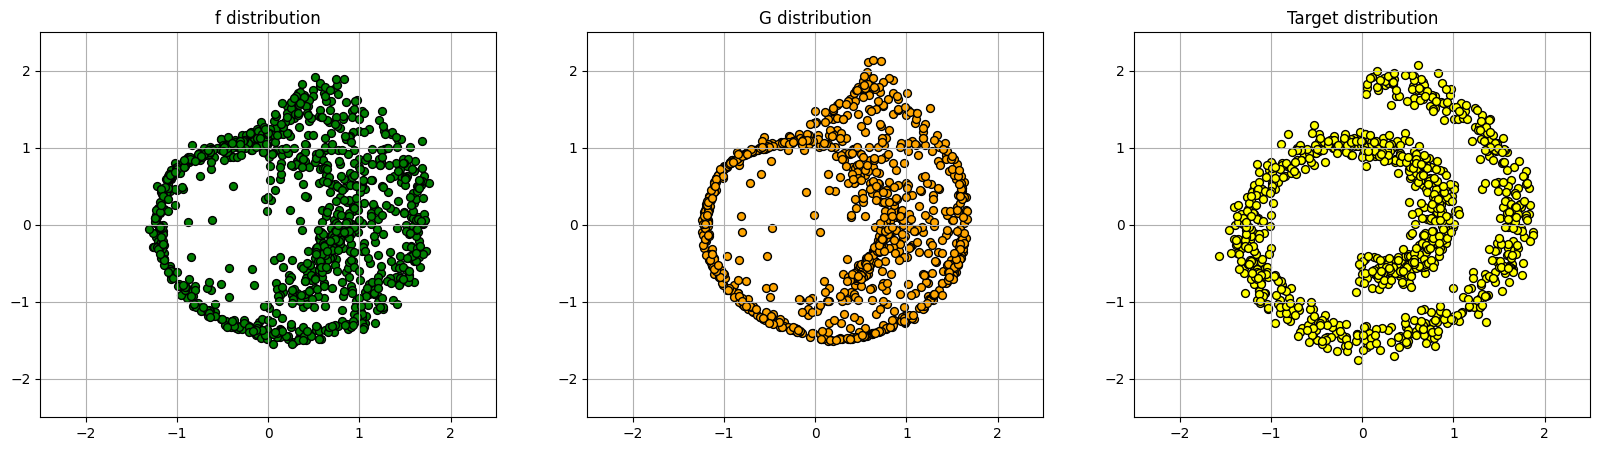

  1%|          | 1203/100000 [01:05<1:55:01, 14.32it/s]

tensor(0.1573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1622, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1654, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 1207/100000 [01:05<1:40:08, 16.44it/s]

tensor(0.1667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1668, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1683, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1714, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 1211/100000 [01:05<1:32:49, 17.74it/s]

tensor(0.1669, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 1216/100000 [01:05<1:29:09, 18.47it/s]

tensor(0.1592, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1479, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1419, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [5]:
train(X_sampler, Y_sampler, f, f_opt, G, G_opt, D, D_opt, sde, plot_n_samples=1000)